In [1]:
!pip install lpips

     |████████████████████████████████| 53 kB 2.0 MB/s 


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Reading rectified left and right images from files

In [3]:
left_img = cv2.imread('left.jpeg')
left_img = np.moveaxis(left_img, -1, 0)

right_img = cv2.imread('right.jpeg')
right_img = np.moveaxis(right_img, -1, 0)

In [4]:
left_img.shape, right_img.shape

((3, 750, 899), (3, 750, 899))

### Cut image on fixed size windows with `functional.unfold` operation

In [16]:
import lpips
import torch
from torch.nn import functional as f

# prepare variables for window search
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)
window_size = 17
padding = 8
max_disparity = 200
smoothing = 0.8

# Compute all possible windows for left image
all_left_windows = f.unfold(
        torch.tensor(left_img, dtype=torch.float)[None,:], 
        kernel_size=window_size, 
        padding=padding,)\
    .to(device)\
    .squeeze()\
    .view(3, window_size, window_size, -1)\
    .permute(3, 0, 1, 2)

# Compute all possible windows for right image
all_right_windows = f.unfold(
        torch.tensor(right_img, dtype=torch.float)[None,:], 
        kernel_size=window_size, 
        padding=padding,)\
    .to(device)\
    .squeeze()\
    .view(3, window_size, window_size, -1)\
    .permute(3, 0, 1, 2)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


In [26]:
print(f"""Tensor of all windows have shape: N x C x H x W
all_right_windows: {all_right_windows.shape}
all_left_windows : {all_left_windows.shape}""")

Tensor of all windows have shape: N x C x H x W
all_right_windows: torch.Size([674250, 3, 17, 17])
all_left_windows : torch.Size([674250, 3, 17, 17])


In [25]:
from tqdm.notebook import trange, tqdm

def spatial_average(in_tens, keepdim=True):
    return in_tens.mean([2,3], keepdim=keepdim)

def upsample(in_tens, out_HW=(64,64)): # assumes scale factor is same for H and W
    in_H, in_W = in_tens.shape[2], in_tens.shape[3]
    return nn.Upsample(size=out_HW, mode='bilinear', align_corners=False)(in_tens)

def compute_embeddings(windows, loss_model):
    """
    Computes activations from multiple layers 
    of encoder model e.g. vgg or alex net

    @params: windows - List of patches to be processed
    @params: loss_model - Perceptuall loss model from pipl library
    @returns: Activations from multiple layers 
    """
    input = loss_model.scaling_layer(windows)\
                if loss_model.version=='0.1'\
                else windows
    out  = loss_model.net.forward(input)

    return out

def compute_distance(left_emb, right_emb, loss_model):
    """
    This method applies pretraned convolution layers from pipl library

    @params: left_emb  - Activations for left pathes
    @params: right_emb - Activations for right pathes
    @params: loss_model - Perceptuall loss model from pipl library
    """
    diffs = []
    for kk in range(loss_model.L):
        feats0, feats1 = lpips.normalize_tensor(left_emb[kk]), lpips.normalize_tensor(right_emb[kk])
        diffs.append((feats0-feats1)**2)

    if loss_model.lpips :
        if loss_model.spatial:
            res = [upsample(loss_model.lins[kk].model(diffs[kk]), out_HW=in0.shape[2:]) for kk in range(loss_model.L)]
        else:
            res = [spatial_average(loss_model.lins[kk].model(diffs[kk]), keepdim=True) for kk in range(loss_model.L)]
    else:
        if loss_model.spatial:
            res = [upsample(diffs[kk].sum(dim=1,keepdim=True), out_HW=in0.shape[2:]) for kk in range(loss_model.L)]
        else:
            res = [spatial_average(diffs[kk].sum(dim=1,keepdim=True), keepdim=True) for kk in range(loss_model.L)]
    
    return sum(res)

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def compute_row_embeddings(row_windows, img, loss_model, device):
    """
    Computes embeddings for every pathes in specific row of image

    @params: row_windows - Patches of row 
    @params: img - Images
    @params: loss_model - Perceptuall loss model from pipl library
    @params: device - Torch device e.g. CUDA or CPU
    @returns: Row of embeddings
    """
    row_embeddings = []

    # create channel tensors for very activation
    for channel, size in zip(loss_model.chns, [17, 8, 4, 2, 1]):
        channel_tensor = torch.ones(img.shape[2], channel, size, size)\
                            .to(device)
        row_embeddings.append(channel_tensor)

    # fill channel tensors by processing chunks
    chunk_size = 10
    for i in range(0, row_windows.shape[0], chunk_size):
        activations = compute_embeddings(row_windows[i:i+chunk_size], loss_model)
        for c, channel_tensor in enumerate(row_embeddings):
            channel_tensor[i:i+len(activations[c])] = activations[c]
    
    return row_embeddings

def slice_windows(windows, img, i, j, size):
    """
    Create a row slice of patches for specific image

    @params: windows - List of all patches coresponding to image
    @params: img - Image
    @params: i - number of row to start slice
    @params: j - number of column to start slice
    @params: size - size of a slice
    @returns: slize of pathes corresponding to i, j params
    """
    shift = i*img.shape[2]
    left  = shift + j
    right = min(left + size, windows.shape[0])

    return windows[left: right]

### Perform windows search
**Description**  
We iterate over every pixel in right image. In every row we compute embeddings/activations of encoder network (vgg) for both left and right image.   
Then for every pixel in the row of right image we find the most close point in left image in a same row. Eventually distance in pixel space is saved to disparity map.  

**Computation improvements**  
To speed up computation we decomposed vgg evaluation and cnn evaluation + the search of the closest point is restricted by `max_disparity` value

In [19]:
from tqdm.notebook import trange, tqdm
import time

size_of_chunk = 50
disparity_map = torch.zeros(right_img.shape[1:]).float()
for y in trange(right_img.shape[1]):
    # geting row embeddings for right image
    right_row_windows = slice_windows(all_right_windows, right_img, y, 0, right_img.shape[2])
    right_row_embeddings = compute_row_embeddings(right_row_windows, right_img, loss_fn_vgg, device)
    # geting row embeddings for right image
    left_row_windows = slice_windows(all_left_windows, left_img, y, 0, left_img.shape[2])
    left_row_embeddings = compute_row_embeddings(left_row_windows, left_img, loss_fn_vgg, device) 

    # iterating over embeddigns
    iter_list = list(range(right_img.shape[2]))
    for x_chunk in chunks(iter_list, size_of_chunk):
        # define batch, where every nested list correspond
        # to specific channel e.g number of layer in vgg 
        # from where we took activation
        left_batch  = [[],[],[],[],[]]
        right_batch = [[],[],[],[],[]]

        # since batch sizes might be non equal
        # remember them for later use
        batch_sizes = []

        # collect embeddings for x in chunk
        for x in x_chunk:
            
            # compute postion for rightmost pixel to compare
            L = loss_fn_vgg.L
            windows_num = left_row_embeddings[0].shape[0]
            cut_idx = min(x + max_disparity, windows_num)

            # slice corresponding left and right embeddings
            left_embeddings  = [left_row_embeddings[c][x: cut_idx, :] for c in range(L)]
            right_embeddings = [right_row_embeddings[c][x].expand(len(left_embeddings[0]), -1,-1, -1) for c in range(L)]

            # append them to batch for later concatination
            for c, (l, r) in enumerate(zip(left_embeddings, right_embeddings)):
                left_batch[c].append(l)
                right_batch[c].append(r)

            # save batch size 
            batch_sizes.append(len(left_embeddings[0]))
        
        # concatenate embeddings to one tensor per every channel
        for i in range(len(left_batch)):
            left_batch[i]  = torch.cat(left_batch[i]).to(device)
            right_batch[i] = torch.cat(right_batch[i]).to(device)

        # calculate scores for concatinated embeddings
        distance_scores = compute_distance(right_batch, left_batch, loss_fn_vgg)\
                            .squeeze()
        
        # Calculate argmins for batch
        cnt = 0
        argmins = []
        for size in batch_sizes:
            scores = distance_scores[cnt: cnt+size]
            argmins.append(scores.argmin())
            cnt += size
        
        # set argmin value
        for x, argmin in zip(x_chunk, argmins):
            disparity_map[y, x] = argmin.cpu()


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


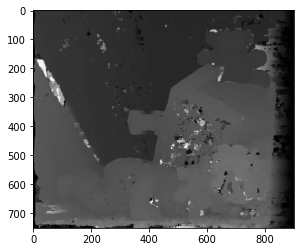

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(disparity_map, cmap='gray', vmin=0, vmax=max_disparity)
plt.show()

In [ ]:
plt.imsave("teddy_pipl_disp.png", disparity_map, cmap='gray', vmin=0, vmax=max_disparity)